#Time Series Forecasting

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

c:\Users\valer\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
data = pd.read_csv('nvidia_historicalData.csv')

In [4]:
data.head()

,Date,Close/Last,Volume,Open,High,Low
0,02/26/2024,$790.92,50397270,$797.00,$806.4599,$785.05
1,02/23/2024,$788.17,82938840,$807.90,$823.94,$775.70
2,02/22/2024,$785.38,86509970,$750.25,$785.75,$742.20
3,02/21/2024,$674.72,69029810,$680.06,$688.88,$662.48
4,02/20/2024,$694.52,70483310,$719.47,$719.56,$677.34


In [6]:
data.dtypes

Date          object
Close/Last    object
Volume         int64
Open          object
High          object
Low           object
dtype: object

In [6]:
for variable in ['Close/Last','Open', 'High', 'Low']:
  data[variable] = data[variable].str[1:].astype(float)
data['Date'] = pd.to_datetime(data['Date'])

In [4]:
data.describe()

,Close/Last,Volume,Open,High,Low
count,2516.000000,2.516000e+03,2516.000000,2516.000000,2516.000000
mean,110.132544,4.603285e+07,110.039583,112.017975,108.007140
std,134.313287,2.547570e+07,134.171776,136.493783,131.745522
min,4.196300,4.564512e+06,4.232500,4.325000,4.192500
25%,15.494375,2.972082e+07,15.476875,15.623125,15.268750
50%,54.023750,4.076254e+07,54.080000,55.193700,53.220450
75%,153.885625,5.565206e+07,153.880000,157.265950,151.251875
max,790.920000,3.688132e+08,807.900000,823.940000,785.050000


In [5]:
data['Date'].min(), data['Date'].max()

(Timestamp('2014-02-27 00:00:00'), Timestamp('2024-02-26 00:00:00'))

The dataset covers 10 years of history, for a total of 2516 trading days.

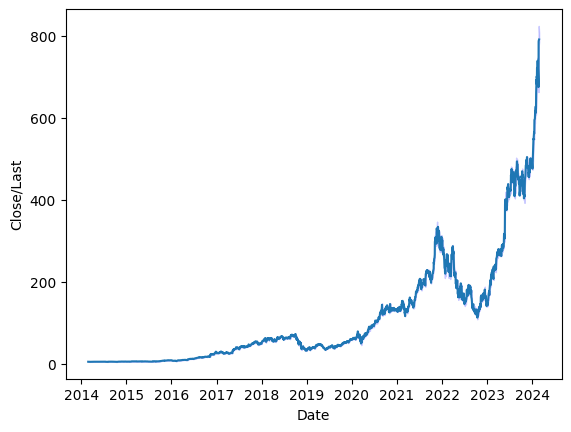

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1)

sns.lineplot(data=data, x='Date', y='Close/Last', ax= ax)
ax.fill_between(data['Date'], data['Low'], data['High'], color='b', alpha=0.2)

<Axes: xlabel='Date', ylabel='Volume'>

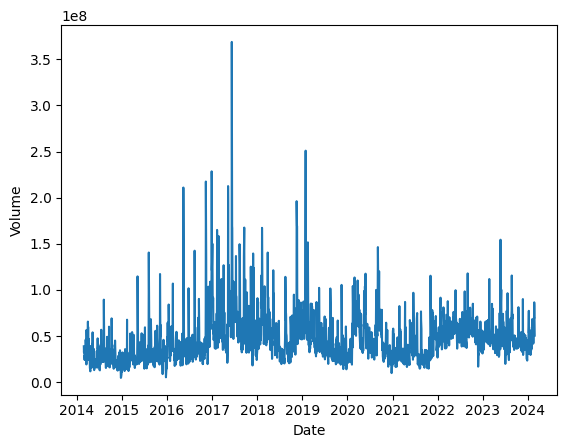

In [ ]:
sns.lineplot(data=data, x='Date', y='Volume')

(array([19723., 19730., 19737., 19744., 19754., 19761., 19768., 19775.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

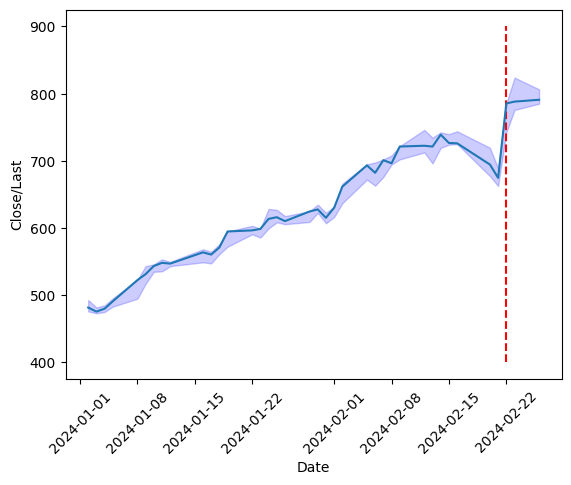

In [9]:
ytd = data.loc[data['Date'] >= '2024-01-01']

fig, ax = plt.subplots(nrows=1, ncols=1)

sns.lineplot(data=ytd, x='Date', y='Close/Last', ax= ax)
ax.fill_between(ytd['Date'], ytd['Low'], ytd['High'], color='b', alpha=0.2)
ax.vlines(x=datetime.strptime('2024-02-22', '%Y-%m-%d'), ymin=400, ymax=900, color='r', linestyles ='dashed')
plt.xticks(rotation=45)

Since the beginning of the year, NVIDIA as frequently closed at the highest value of the day. I also notice a big jump in prices (highlighted in correspondance of the red dashed line) on February 22nd, due to NVIDIA announcing Financial Results that exceeded expectations.

I decompose the time series using an additive approach in order to obtain the potential components of trend (which is visible from the raw data, given its upward trend) and seasonality.

I first look for a montly seasonality (on avarage 21 trading days per month).

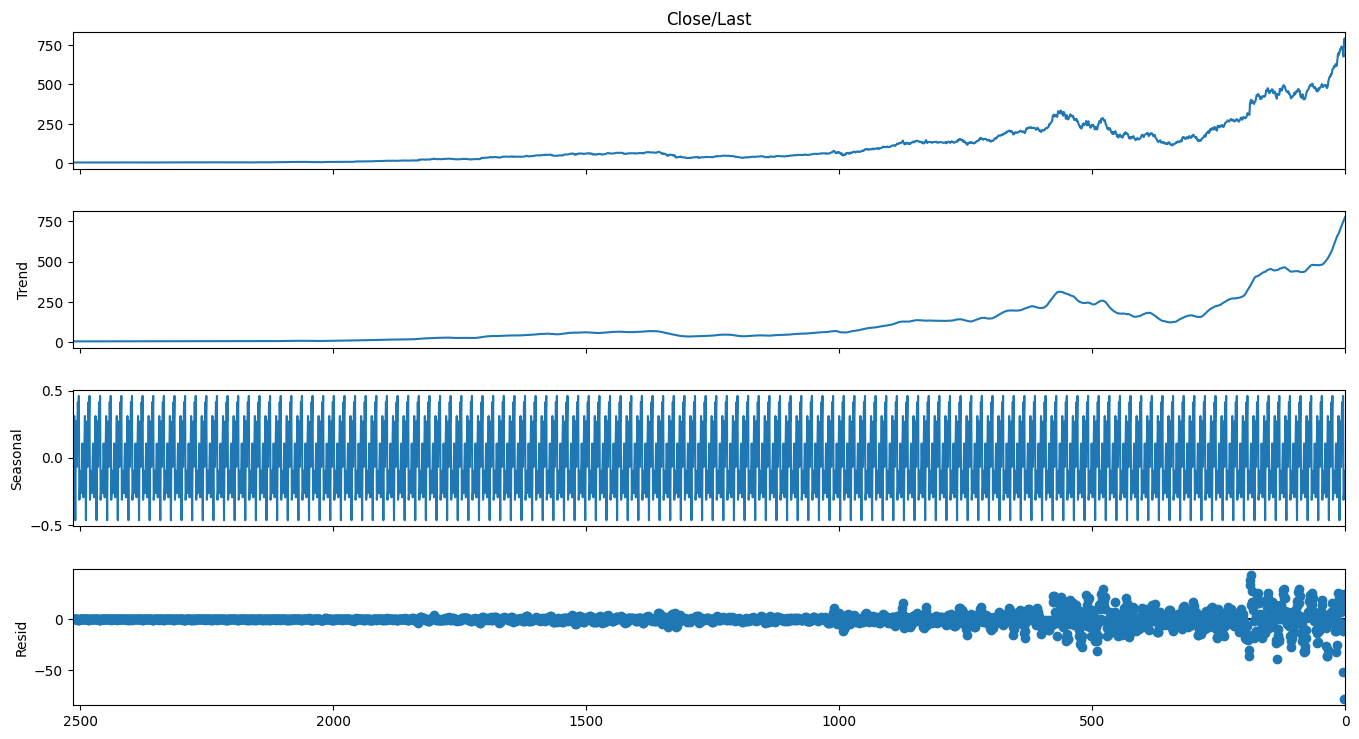

In [ ]:
res = sm.tsa.seasonal_decompose(data.sort_values(by='Date')['Close/Last'], model='additive', extrapolate_trend='freq', period=21)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

We compare it with the multiplicative approach.

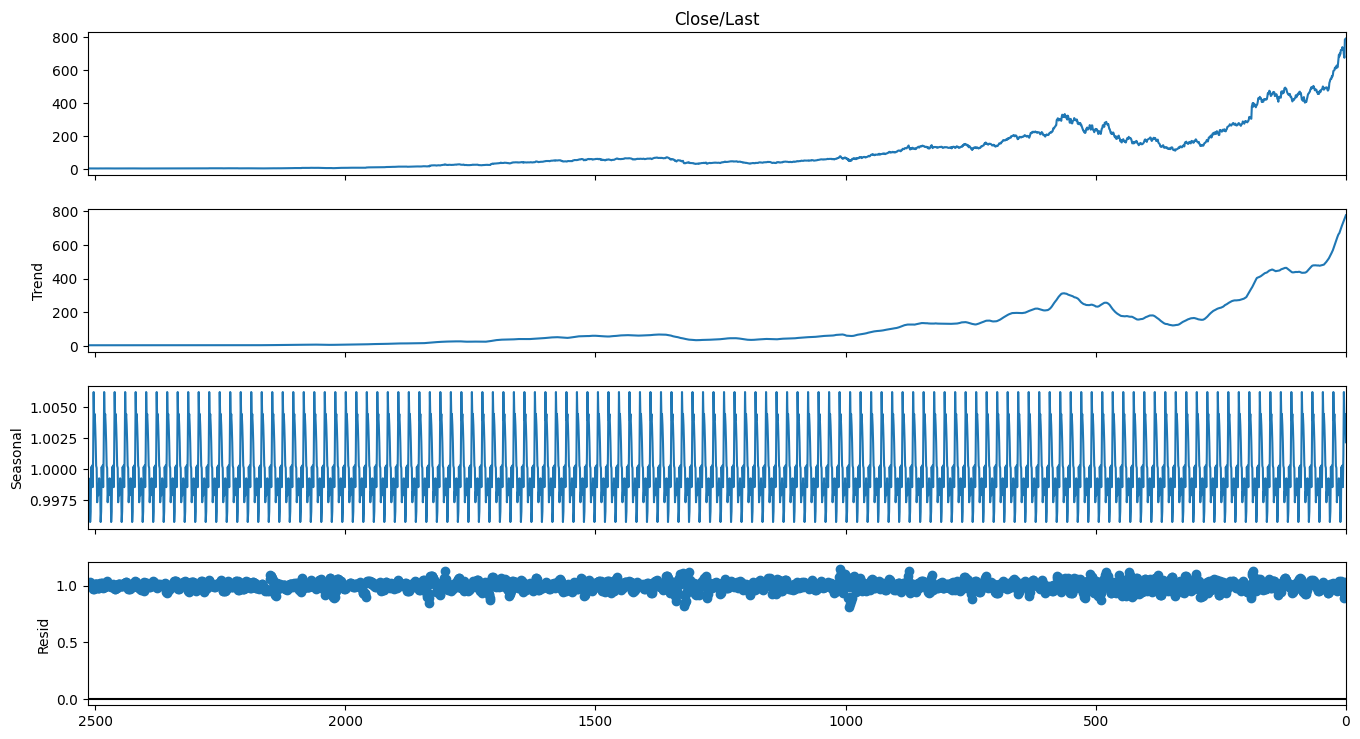

In [ ]:
res = sm.tsa.seasonal_decompose(data.sort_values(by='Date')['Close/Last'], model='multiplicative', extrapolate_trend='freq', period=21)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

By looking at the residuals, it is visible that a multiplicative join of the trend and the seasonality is more suited for this case. In fact, the spread of the residuals is constant across the entire time series. Therefore, this indicates that the variation in the data not explained by trend and seasonality is consistent over time.

Let's also look at a yearly seasonality (252 trading days).

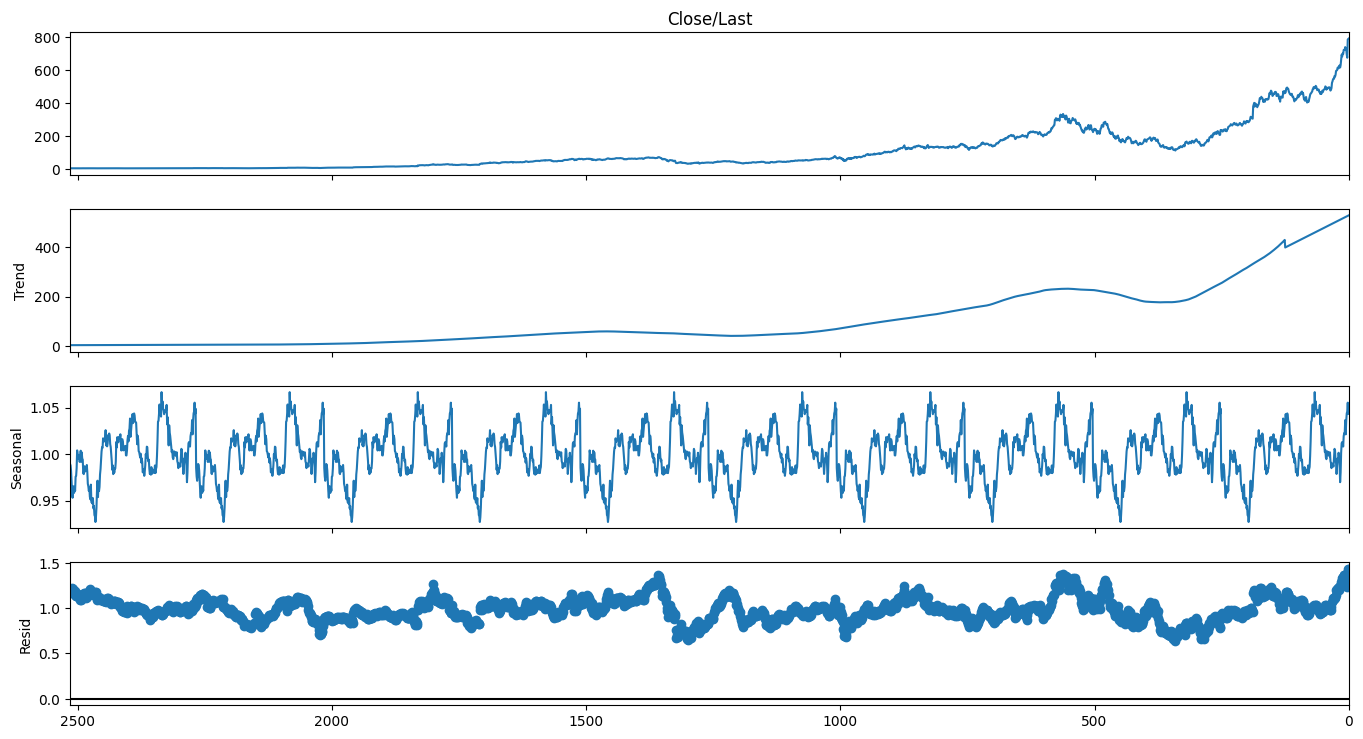

In [ ]:
res = sm.tsa.seasonal_decompose(data.sort_values(by='Date')['Close/Last'], model='multipicative', extrapolate_trend='freq', period=252)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

Yearly seasonality is not able to fit properly the data at the start and end of the period of analysis. Therefore, I proceed considering a seasonal component of 21 trading days.

Let's move to the forecasting phase.

First we split train and test data. We train using data up to 2023. 2024 will be used for testing.

In [6]:
train = data.sort_values(by='Date').loc[data['Date'] < '2024-01-01']['Close/Last']
test = data.sort_values(by='Date').loc[data['Date'] >= '2024-01-01']['Close/Last']

We have to choose a model, after confirming that data has a trend or not. To do this, I look at stationarity by using the Augmented Dickey-Fuller unit root test.

I test the original and the differenced time series to compare the potential change in stationarity.

In [7]:
#ADF-test(original time-series)
res = sm.tsa.adfuller(data['Close/Last'],regression='ct')
print('p-value:{}'.format(res[1]))

p-value:0.015598999297803572


In [8]:
#ADF-test(differenced time-series)
res = sm.tsa.adfuller(data['Close/Last'].diff().dropna(),regression='c')
print('p-value:{}'.format(res[1]))

p-value:1.260657554590996e-15



Original data is not stationary, while the differenced one is. Then the time series is a unit root process. In this case we can use ARIMA or SARIMA model for prediction.

Before applying the model, we need to retrieve the model parameters of trend and seasonality.

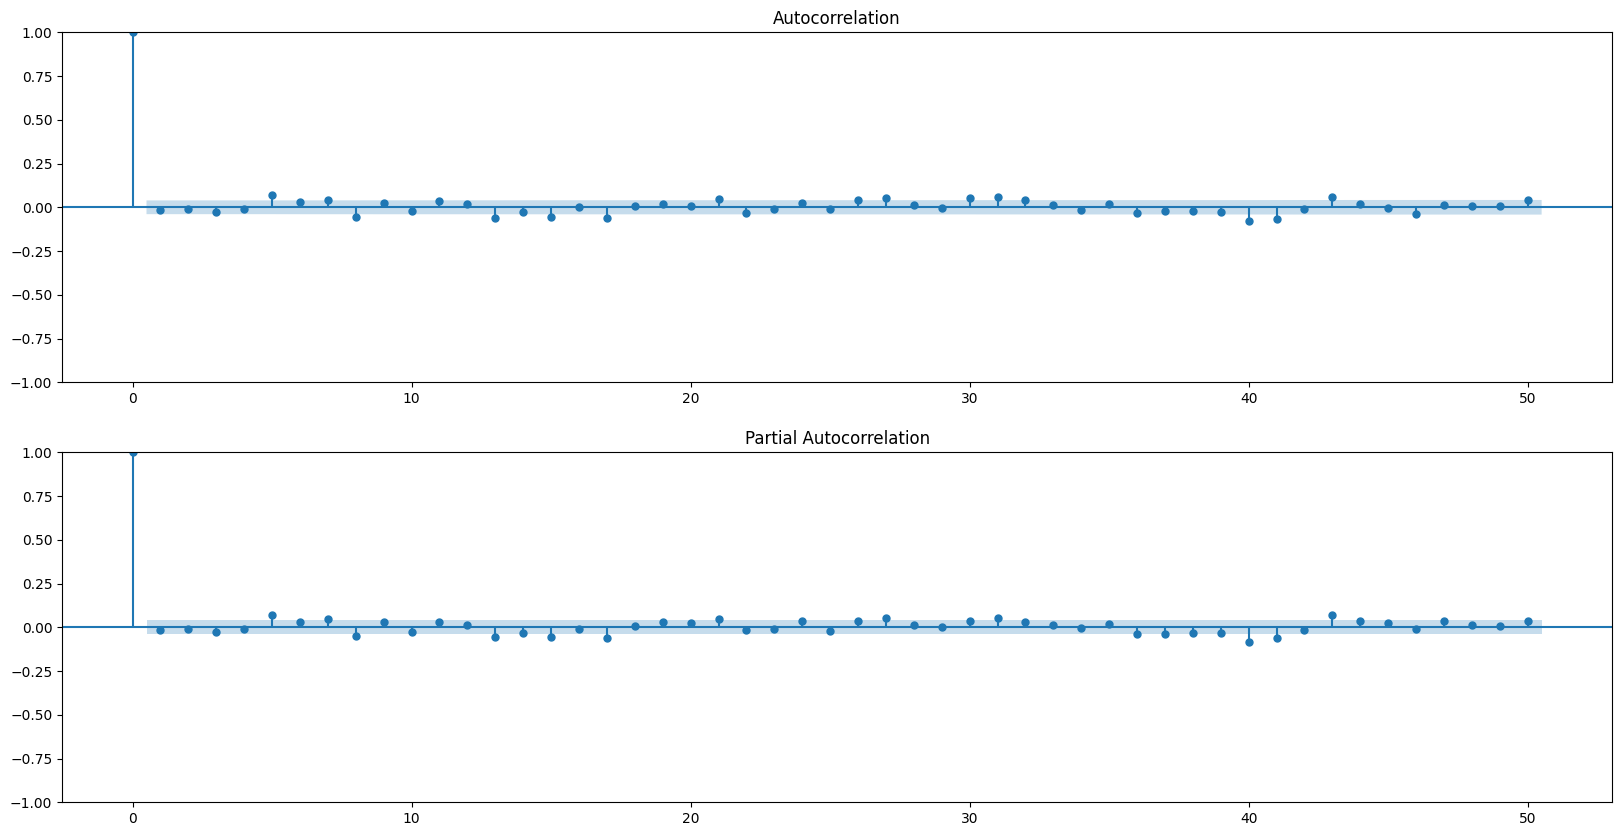

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(train.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train.diff().dropna(), lags=50, ax=ax[1])
plt.show()

From the analysis of Autocorrelations, there are no cut-offs useful for defining the model parameters.

Therefore, I employ an automatic detection of the model order.

In [ ]:
resDiff = sm.tsa.arma_order_select_ic(train, max_ar=10, max_ma=10, ic='aic', trend='c')

In [ ]:
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

In [9]:
# (p, d, q) for the autoregressive, differencing, and moving average components
arima_order = (5, 1, 5)

# Specify the order of the seasonal ARIMA model
# (P, D, Q, S) for the seasonal autoregressive, seasonal differencing,
seasonal_order = (5, 1, 5, 21)

# Fit the SARIMAX model with multiplicative seasonality
model = sm.tsa.statespace.SARIMAX(
    train.values,
    order=arima_order,
    seasonal_order=seasonal_order,
    simple_differencing=False,
    enforce_stationarity=False,
    trend="ct",
    error_correction=False,
    seasonal="mul",  # Set seasonality to multiplicative due to previous analysis of decomposition
)

# Fit the model
model_fit = model.fit()

# Print the fitted model summary
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 2478
Model:             SARIMAX(5, 1, 5)x(5, 1, 5, 21)   Log Likelihood               -7205.431
Date:                            Mon, 04 Mar 2024   AIC                          14456.863
Time:                                    10:01:55   BIC                          14589.344
Sample:                                         0   HQIC                         14505.116
                                           - 2478                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0035      0.155     -0.023      0.982      -0.307       0.300
drift       8.195e-06   8.01e-05   

In [10]:
from sklearn.metrics import mean_squared_error

pred = model_fit.predict(1,38)
print('SARIMAX model MSE:{}'.format(mean_squared_error(test,pred)))

SARIMAX model MSE:399975.88704879774


In [14]:
df = pd.DataFrame(test.to_list(), columns=['test'])
df['pred'] = pred

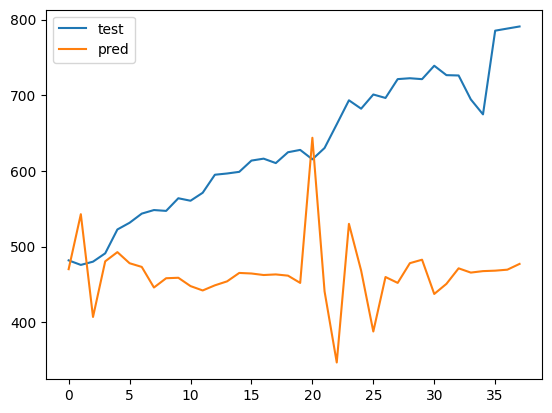

In [16]:
df.plot()
plt.show()

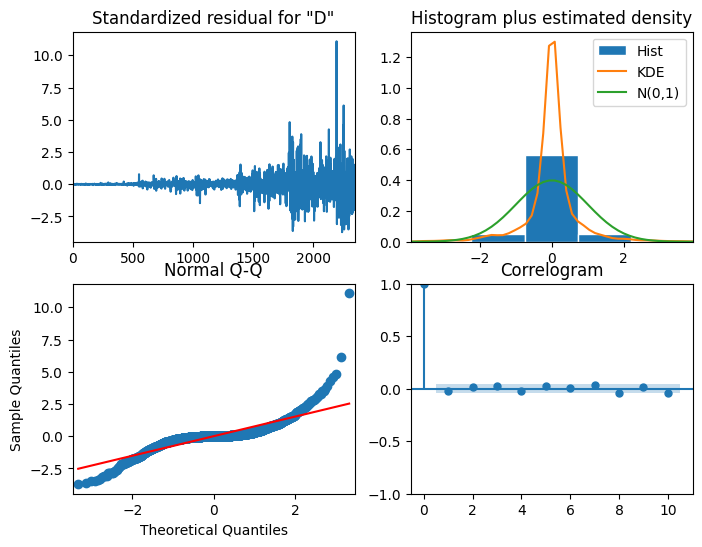

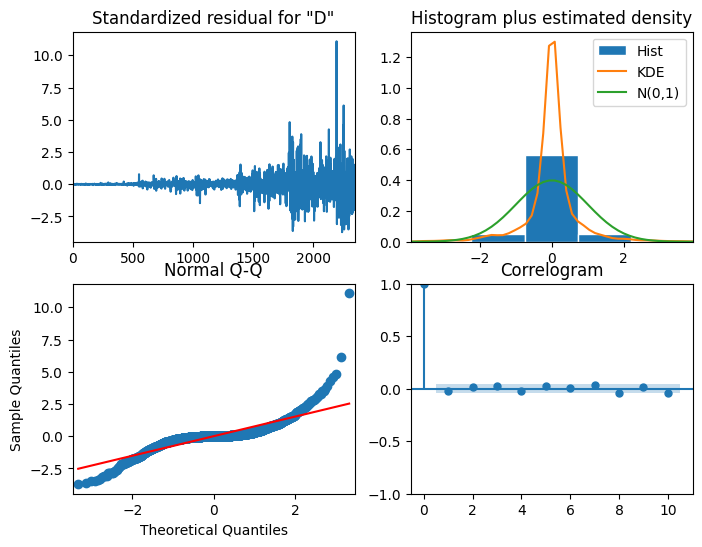

In [ ]:
model_fit.plot_diagnostics(figsize=(8, 6))

Generally, the SARIMA model seems to not being able of fitting the data at hand. In fact, the p-value of the autoregressive and moving average terms is high, leading to non-significant results.
Furthermore, even the test phase shows very important errors.

## LSTM


In [7]:
from sklearn.preprocessing import MinMaxScaler

In [26]:
train = data.sort_values(by='Date').loc[data['Date'] < '2024-01-01']['Close/Last'].values
test = data.sort_values(by='Date').loc[data['Date'] >= '2024-01-01']['Close/Last'].values

sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(train.reshape(-1, 1))

X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
  X_train.append(training_set_scaled[i - 60:i, 0])
  y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [27]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=80, return_sequences=True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=30))
regressor.add(Dropout(0.3))

regressor.add(Dense(units=1))


regressor.compile(optimizer='adam',loss='mean_squared_error')

In [28]:
regressor.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - loss: 0.0201
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0037
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - loss: 0.0038
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 0.0027
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 0.0028
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0025
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - loss: 0.0022
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0022
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 0.0026
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 0.0021
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - loss: 0.0023
Epoch 12/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0019
Epoch 13/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0021
Epoch 14/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 0.0020
Epoch 15/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - loss: 0.0018
Epo

In [29]:
train = data.sort_values(by='Date').loc[data['Date'] < '2024-01-01']['Close/Last']
test = data.sort_values(by='Date').loc[data['Date'] >= '2024-01-01']['Close/Last']

# pre-processing the data
dataset_total = data.sort_values(by='Date')['Close/Last']
inputs = dataset_total[len(dataset_total)-len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# making the test data
X_test = []
for i in range(60,len(inputs)):
  X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


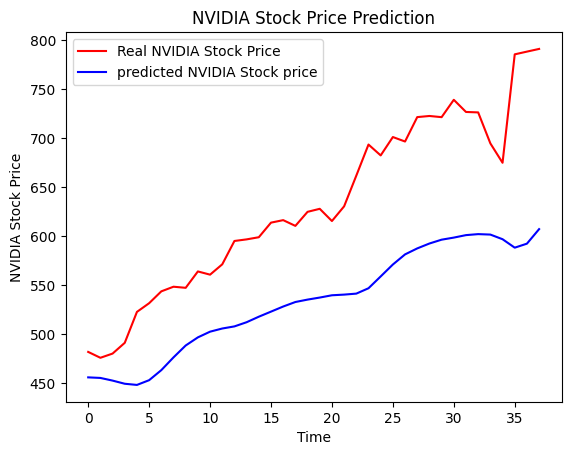

In [30]:
def plot_prediction(test,prediction):
    plt.plot(test,color='red',label="Real NVIDIA Stock Price")
    plt.plot(prediction, color="blue",label="predicted NVIDIA Stock price")
    plt.title("NVIDIA Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("NVIDIA Stock Price")
    plt.legend()
    plt.show()
# now we'll use this function to visualize our test and predicted data

plot_prediction(test.values,predicted_stock_price)

In [31]:
import math

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test,predicted))
    print("The root mean sqaured error is {}.".format(rmse))

return_rmse(test.values,predicted_stock_price)

The root mean sqaured error is 105.7660341452523.


In [32]:
from keras.layers import GRU

regressorGRU = Sequential()

regressorGRU.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.3))
# Second GRU layer
regressorGRU.add(GRU(units=80, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.1))
# Fourth GRU layer
regressorGRU.add(GRU(units=30, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))

# Compiling the RNN
regressorGRU.compile(optimizer='adam',loss='mean_squared_error')

# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 257ms/step - loss: 0.0251
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - loss: 0.0034
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - loss: 0.0026
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - loss: 0.0022
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - loss: 0.0019
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - loss: 0.0021
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - loss: 0.0025
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - loss: 0.0016
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - loss: 0.0017
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - loss: 0.0018
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - loss: 0.0016
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - loss: 0.0017
Epoch 13/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - loss: 0.0017
Epoch 14/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - loss: 0.0017
Epoch 15/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - l

In [33]:
X_test = []
for i in range(60,len(inputs)):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressorGRU.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000022B13771940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


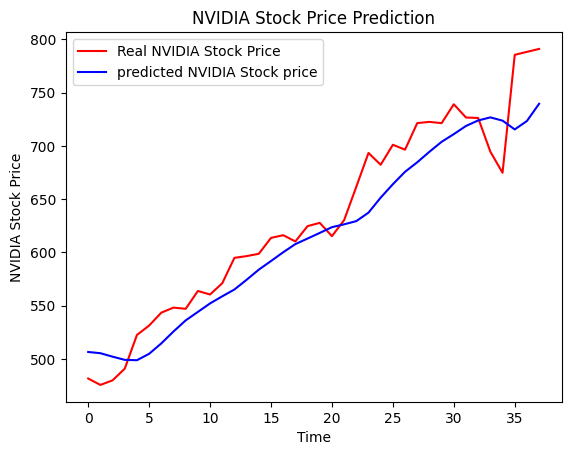

In [34]:
plot_prediction(test.values,predicted_stock_price)

In [35]:
return_rmse(test.values,predicted_stock_price)

The root mean sqaured error is 29.661563073320515.


The prediction of the trend of the price has improved, nevertheless the exact prediction is not quite right. 

For further improvements, it might be useful to incorporate other variables, like the publication of performance reports that can influence traders' behaviour.